In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
!ls

__notebook__.ipynb  __output__.json


We will use Keras-BERT and adapters available in keras for finetuning.


In [3]:
!pip install keras-bert
!pip install keras-rectified-adam

!wget -q https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip -o uncased_L-12_H-768_A-12.zip

  Created wheel for keras-bert: filename=keras_bert-0.78.0-cp36-none-any.whl size=37882 sha256=3810773968a5f6fbae7e088df2b4a125dd0eb8b2e918ff6310dd314eb397e400
  Stored in directory: /tmp/.cache/pip/wheels/9f/2a/a3/a4741e16520a3d651bf895e5fba34d886a993efdbb303ffc11
  Created wheel for keras-transformer: filename=keras_transformer-0.30.0-cp36-none-any.whl size=13388 sha256=367cd207d9e113db626697aaee465921fc5449c9e2e6e963ac3ab38ae9a09429
  Stored in directory: /tmp/.cache/pip/wheels/b5/06/e3/172763eea3a0b3046c91a75ec778c54e55f96ee0efdb79c044
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7553 sha256=4b6985878f2806bdd8fca265df124d1b7a9104b3ff2ce21508cfa142de89b4f5
  Stored in directory: /tmp/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=66d30aa913621cb50df49b5d709e8c7e8f1f6e45191db7f0d91ad09ab7e08ab8
  Stored 

In [4]:
import codecs
import tensorflow as tf
from tqdm import tqdm
from chardet import detect
import keras
from keras_radam import RAdam
from keras import backend as K
from keras_bert import load_trained_model_from_checkpoint
# from google.colab import drive



/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

**PARAMETERS**

In [5]:

SEQ_LEN = 128
BATCH_SIZE = 50
EPOCHS = 7
LR = 1e-4

**Path to the pre trained model of BERT.**

In [6]:


pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')


**Loading Pretrained BERT model.**

In [7]:
model = load_trained_model_from_checkpoint(
      config_path,
      checkpoint_path,
      training=True,
      trainable=True,
      seq_len=SEQ_LEN,
  )

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
__________________________________________________________________________________________________
Embedding-

**Extracting token dictionary from vocab of pretrained model to refer for input we will be using.**

In [9]:
import codecs
from keras_bert import Tokenizer
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)
        
# print(token_dict)

**Downloading dataset.**

In [10]:
# @title Download I20Newsgroup dataset
import tensorflow as tf

dataset = tf.keras.utils.get_file(
    fname="20news-18828.tar.gz", 
    origin="http://qwone.com/~jason/20Newsgroups/20news-18828.tar.gz", 
    extract=True,
)

14671872/14666916 [==============================] - 3s 0us/step


**Defining Tokenizer.**

In [11]:
tokenizer = Tokenizer(token_dict)


**Making Label , index pair.**

In [12]:
datapath = ".".join(dataset.split(".")[:-2])
txtfiles = os.listdir(datapath)
labels = [(x, i) for i,x in enumerate(txtfiles)]
def get_label(index):
    for each in labels:
        if index == each[1]:
            return each[0]
    
    

**Splitting data into train, test preceded by tokenizing sentences and returning test train data. **

In [13]:
def load_data(path, labels):
    global tokenizer
    indices, sentiments = [], []
    for folder, sentiment in labels:
        folder = os.path.join(path, folder)
        for name in tqdm(os.listdir(folder)):
            with open(os.path.join(folder, name), 'r', encoding="utf-8", errors='ignore') as reader:
                  text = reader.read()
            ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
            indices.append(ids)
            sentiments.append(sentiment)
    items = list(zip(indices, sentiments))
    
    np.random.shuffle(items)
    test_items = items[int(0.8*len(items)):]
    train_items = items[:int(0.8*len(items))]
    indices_test, sentiments_test = zip(*test_items)
    indices_train, sentiments_train = zip(*train_items)
    indices_train = np.array(indices_train)
    indices_test = np.array(indices_test)
    mod_train = indices_train.shape[0] % BATCH_SIZE
    mod_test = indices_test.shape[0] % BATCH_SIZE
    if mod_train > 0:
        indices_train, sentiments_train = indices_train[:-mod_train], sentiments_train[:-mod_train]
    if mod_test > 0:
      indices_test, sentiments_test = indices_test[:-mod_test], sentiments_test[:-mod_test]

    return [indices_train, np.zeros_like(indices_train)], np.array(sentiments_train),[indices_test, np.zeros_like(indices_test)], np.array(sentiments_test)
  
train_path = os.path.join(os.path.dirname(dataset), '20news-18828')
train_x, train_y, test_x, test_y = load_data(train_path, labels)

100%|██████████| 990/990 [00:04<00:00, 209.32it/s]


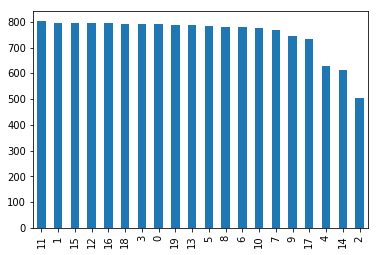

In [14]:
pd.Series(train_y).value_counts().plot(kind = 'bar')

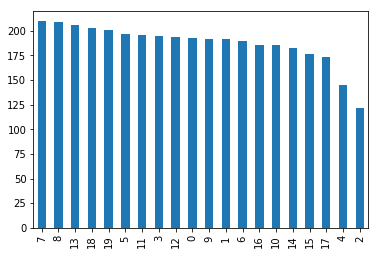

In [15]:
pd.Series(test_y).value_counts().plot(kind = 'bar')

**Extracting layer from pretrained bert model and adding a layer with softmax function to classify 20 classes of news.**

In [16]:
inputs = model.inputs[:2]
dense = model.get_layer('NSP-Dense').output
outputs = keras.layers.Dense(units=20, activation='softmax')(dense)

model = keras.models.Model(inputs, outputs)
model.compile(
  RAdam(learning_rate =LR),
  loss='sparse_categorical_crossentropy',
  metrics=['sparse_categorical_accuracy'],
)


**Initializing variables.**

In [17]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables]
)
sess.run(init_op)


**Finally, training the model.**

In [18]:
# @title Fit

model.fit(
    train_x,
    train_y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

Epoch 1/7
15050/15050 [==============================] - 236s 16ms/step - loss: 1.4068 - sparse_categorical_accuracy: 0.5813
Epoch 2/7
15050/15050 [==============================] - 214s 14ms/step - loss: 0.3577 - sparse_categorical_accuracy: 0.8896
Epoch 3/7
15050/15050 [==============================] - 214s 14ms/step - loss: 0.1697 - sparse_categorical_accuracy: 0.9494
Epoch 4/7
15050/15050 [==============================] - 214s 14ms/step - loss: 0.1055 - sparse_categorical_accuracy: 0.9686
Epoch 5/7
15050/15050 [==============================] - 214s 14ms/step - loss: 0.0858 - sparse_categorical_accuracy: 0.9737
Epoch 6/7
15050/15050 [==============================] - 214s 14ms/step - loss: 0.0727 - sparse_categorical_accuracy: 0.9778
Epoch 7/7
15050/15050 [==============================] - 214s 14ms/step - loss: 0.0690 - sparse_categorical_accuracy: 0.9787


**Making prediction for test dataset.**

In [19]:


predicts = model.predict(test_x, verbose=True).argmax(axis=-1)

3750/3750 [==============================] - 19s 5ms/step


**Calculating accuracy.**

In [20]:

print(np.sum(test_y == predicts) / test_y.shape[0])

0.9077333333333333


**Inference**

In [21]:

test_text = """The Mumbai batsman is set to replace underperforming KL Rahul as an opener in upcoming Test series against South Africa in home conditions.India’s newly-appointed batting coach Vikram Rathour feels opener Rohit Sharma is “too good a player” to not be playing in all three formats. Rathour, like many former cricketers, backed Rohit to open for India in Test cricket.“He is too good a player to not be playing in any game. That is what is everyone is thinking. He has done so well in white-ball cricket as an opener so there is no reason why he can’t succeed as a Test opener provided he gets enough opportunities,” Rathour believes Rohit can be an asset to his team if he does good against South Africa in Tests."""
test = """Senate Democrats are planning to hold the floor on Tuesday evening for an hours-long talk-a-thon on the issue of gun violence.The floor marathon comes as the White House is struggling to find a place to land in the weeks-long debate over potential gun-law reforms.“Many of my colleagues have seen their communities torn apart by gun violence; some by horrific mass shootings, others by a relentless, daily stream. Many of them have worked for years to bring commonsense gun safety measures before the Senate,” Senate Minority Leader Charles Schumer (D-N.Y.) said Tuesday, in announcing the plan from the Senate floor."""
ids, segments = tokenizer.encode(test, max_len=SEQ_LEN)

In [22]:
inpu = np.array(ids).reshape([1, SEQ_LEN])
get_label(model.predict([inpu,np.zeros_like(inpu)]).argmax(axis=-1)[0])


'talk.politics.guns'

In [23]:
ids, segments = tokenizer.encode(test_text, max_len=SEQ_LEN)
inpu = np.array(ids).reshape([1, SEQ_LEN])
get_label(model.predict([inpu,np.zeros_like(inpu)]).argmax(axis=-1)[0])

'rec.sport.baseball'